In [ ]:
!kaggle datasets download pkdarabi/brain-tumor-image-dataset-semantic-segmentation

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation
License(s): Attribution 4.0 International (CC BY 4.0)
 78% 65.0M/83.7M [00:00<00:00, 142MB/s]
100% 83.7M/83.7M [00:00<00:00, 159MB/s]


In [ ]:
!unzip -q brain-tumor-image-dataset-semantic-segmentation.zip

## Importing Libraries

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import warnings
import tensorflow as tf
from tensorflow.keras import mixed_precision
warnings.filterwarnings('ignore')

In [ ]:
print(tf.__version__)

In [ ]:
mixed_precision.set_global_policy('mixed_float16')

## Folder Paths

In [ ]:
TRAIN_FOLDER = "./train/"
TEST_FOLDER = "./test/"
VAL_FOLDER = "./valid/"

TRAIN_ANNOTATION = TRAIN_FOLDER + "_annotations.coco.json"
TEST_ANNOTATION = TEST_FOLDER + "_annotations.coco.json"
VAL_ANNOTATION = VAL_FOLDER + "_annotations.coco.json"

## Data Ingestion

In [ ]:
train_coco = COCO(TRAIN_ANNOTATION)
test_coco = COCO(TEST_ANNOTATION)
val_coco = COCO(VAL_ANNOTATION)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
train_coco.cats

{0: {'id': 0, 'name': 'Tumor', 'supercategory': 'none'},
 1: {'id': 1, 'name': '0', 'supercategory': 'Tumor'},
 2: {'id': 2, 'name': '1', 'supercategory': 'Tumor'}}

In [ ]:
print("Training images :", len(train_coco.imgs))
print("Test images :" ,len(test_coco.imgs))
print("Validation images :", len(val_coco.imgs))

Training images : 1502
Test images : 215
Validation images : 429


In [ ]:
print("No of file in category 0:", len(train_coco.catToImgs[0]))
print("No of file in category 1:", len(train_coco.catToImgs[1]))
print("No of file in category 2:", len(train_coco.catToImgs[2]))

No of file in category 0: 0
No of file in category 1: 771
No of file in category 2: 731


## Utility functions for image plotting

In [ ]:
def get_annoted_image(base_dir, dataset, file_id):
    img = cv2.imread(os.path.join(base_dir, dataset.imgs[file_id]['file_name']))
    x, y, width, height = map(int, dataset.anns[file_id]['bbox'])
    img = cv2.rectangle(img, (x, y), (x + width, y + height), color=(255, 0, 0), thickness=2)
    return img

In [ ]:
def get_masked_image(image, mask, color):
    image = image.copy()
    mask = mask.copy()
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image, contours, -1, color, thickness=1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

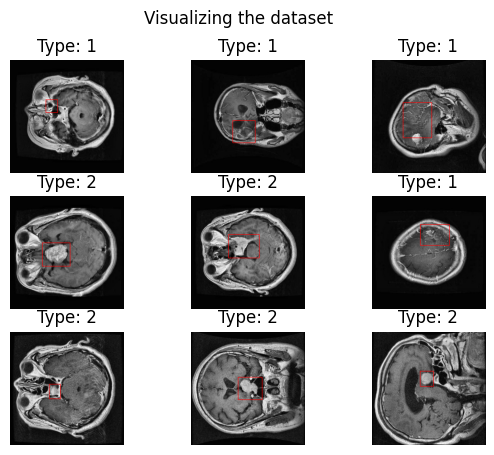

In [ ]:
plt.figure(figsize=(7,5))

indexes = np.random.randint(0, len(train_coco.imgs), 9)
for i, idx in enumerate(indexes):
    plt.subplot(3, 3, i+1)
    img = get_annoted_image(TRAIN_FOLDER, train_coco, idx)
    plt.imshow(img, cmap='gray')
    plt.title(f"Type: {train_coco.anns[idx]['category_id']}")
    plt.axis('off')
plt.subplots_adjust(wspace=0)
plt.suptitle("Visualizing the dataset")
plt.show()

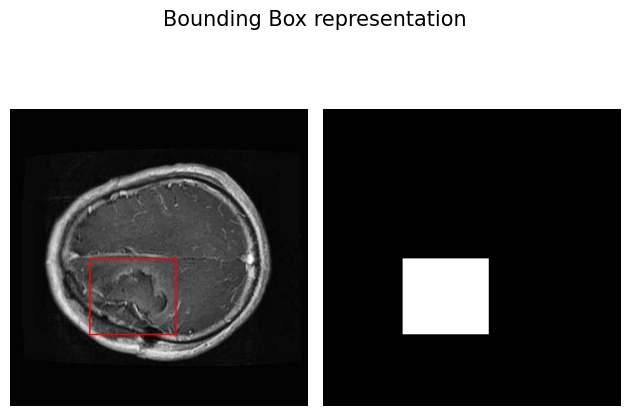

In [ ]:
idx = 400
plt.subplot(121)
img = get_annoted_image(TRAIN_FOLDER, train_coco, idx)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(train_coco.annToMask(train_coco.anns[idx]), cmap='gray')
plt.axis('off')
plt.suptitle("Bounding Box representation", fontsize=15)
plt.tight_layout()
plt.show()

## Data Preparation

In [ ]:
def load_data(base_dir, dataset, height, width):
    images = []
    masks = []
    image_ids = dataset.getImgIds()
    for idx in tqdm(image_ids):
        file = os.path.join(base_dir, dataset.imgs[idx]['file_name'])
        img = cv2.imread(file)
        img = cv2.resize(img, (height, width))
        images.append(img)

        mask = dataset.annToMask(dataset.anns[idx])
        mask = cv2.resize(mask, (height, width))

        masks.append(mask)
    return np.array(images), np.array(masks).reshape((len(masks), height, width, 1))


In [ ]:
train_x, train_y = load_data(TRAIN_FOLDER, train_coco, height=256, width=256)
test_x, test_y = load_data(TEST_FOLDER, test_coco, height=256, width=256)
val_x, val_y = load_data(VAL_FOLDER, val_coco, height=256, width=256)

100%|██████████| 429/429 [00:01<00:00, 214.68it/s]


In [ ]:
train_x.shape, train_y.shape

((1502, 256, 256, 3), (1502, 256, 256, 1))

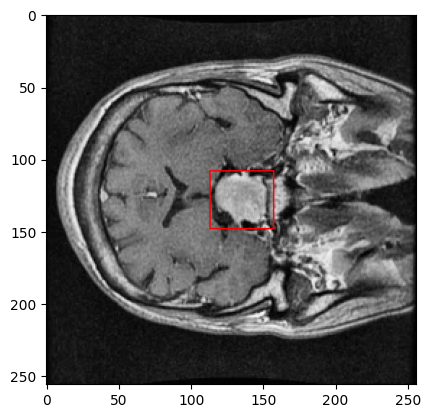

In [ ]:
plt.imshow(get_masked_image(train_x[11], train_y[11], (0,0,255)))

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))

In [ ]:
batch_size = 16
train_dataset = train_dataset.shuffle(buffer_size=100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
def preprocess(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    y = tf.cast(y, tf.float32)
    return x, y

train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)

 ## Model Development

In [ ]:
def unet_model(input_shape, dropout_rate=0.2):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(dropout_rate)(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(dropout_rate)(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(dropout_rate)(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(dropout_rate)(c4)

    # Decoder
    u5 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = tf.keras.layers.concatenate([u5, c3])
    c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = tf.keras.layers.Dropout(dropout_rate)(c5)

    u6 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c2])
    c6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(dropout_rate)(c6)

    u7 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c1])
    c7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(dropout_rate)(c7)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model(input_shape=(256, 256, 3))

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 256, 256, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 256, 256, 32)   │              0 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 128, 128, 32)   │              0 │ dropout_7[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 128, 128, 64)   │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 64)     │              0 │ dropout_8[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 64, 64, 128)    │              0 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 128)    │              0 │ dropout_9[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 32, 32, 256)    │              0 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 64, 64, 128)    │        131,200 │ dropout_10[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 64, 64, 256)    │              0 │ conv2d_transpose_3[0]… │
│ (Concatenate)             │                        │                │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 64, 64, 128)    │        295,040 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 64, 64, 128)    │              0 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4   

 Total params: 948,001 (3.62 MB)

 Trainable params: 948,001 (3.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# early_stopping_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_precision',
#     patience=10,
#     restore_best_weights=True,
#     verbose=1
# )

csv_logger_callback = tf.keras.callbacks.CSVLogger(
    filename='training_log.csv',
    separator=',',
    append=False
)

# def decay_schedule(epoch, lr):
#     if epoch < 15:
#         return lr
#     else:
#         return tf.cast((lr * tf.math.exp(-0.1)), dtype=tf.float32)

# lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(
#     schedule=decay_schedule,
#     verbose=1
# )


callbacks = [checkpoint_callback, csv_logger_callback]

In [ ]:
class PrecisionMetric(tf.keras.metrics.Metric):
    def __init__(self, name='precision', **kwargs):
        super(PrecisionMetric, self).__init__(name=name, **kwargs)
        self.intersect = self.add_weight(name='intersect', initializer='zeros')
        self.total_pixel_pred = self.add_weight(name='total_pixel_pred', initializer='zeros')

    def update_state(self, groundtruth_mask, pred_mask, sample_weight=None):
        groundtruth_mask = tf.cast(groundtruth_mask, tf.float32)
        pred_mask = tf.cast(pred_mask, tf.float32)
        intersect = tf.reduce_sum(pred_mask * groundtruth_mask)
        total_pixel_pred = tf.reduce_sum(pred_mask)
        self.intersect.assign_add(intersect)
        self.total_pixel_pred.assign_add(total_pixel_pred)

    def result(self):
        precision = self.intersect / (self.total_pixel_pred + tf.keras.backend.epsilon())
        return tf.round(precision * 1000) / 1000

    def reset_states(self):
        self.intersect.assign(0)
        self.total_pixel_pred.assign(0)

class RecallMetric(tf.keras.metrics.Metric):
    def __init__(self, name='recall', **kwargs):
        super(RecallMetric, self).__init__(name=name, **kwargs)
        self.intersect = self.add_weight(name='intersect', initializer='zeros')
        self.total_pixel_truth = self.add_weight(name='total_pixel_truth', initializer='zeros')

    def update_state(self, groundtruth_mask, pred_mask, sample_weight=None):
        groundtruth_mask = tf.cast(groundtruth_mask, tf.float32)
        pred_mask = tf.cast(pred_mask, tf.float32)
        intersect = tf.reduce_sum(pred_mask * groundtruth_mask)
        total_pixel_truth = tf.reduce_sum(groundtruth_mask)
        self.intersect.assign_add(intersect)
        self.total_pixel_truth.assign_add(total_pixel_truth)

    def result(self):
        recall = self.intersect / (self.total_pixel_truth + tf.keras.backend.epsilon())
        return tf.round(recall * 1000) / 1000

    def reset_states(self):
        self.intersect.assign(0)
        self.total_pixel_truth.assign(0)

class IoUMetric(tf.keras.metrics.Metric):
    def __init__(self, name='iou', **kwargs):
        super(IoUMetric, self).__init__(name=name, **kwargs)
        self.intersect = self.add_weight(name='intersect', initializer='zeros')
        self.union = self.add_weight(name='union', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        intersect = tf.reduce_sum(y_pred * y_true)
        union = tf.reduce_sum(y_pred) + tf.reduce_sum(y_true) - intersect

        self.intersect.assign_add(intersect)
        self.union.assign_add(union)

    def result(self):
        iou = self.intersect / (self.union + tf.keras.backend.epsilon())
        return tf.round(iou * 1000) / 1000

    def reset_states(self):
        self.intersect.assign(0)
        self.union.assign(0)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), PrecisionMetric(), RecallMetric(), IoUMetric()])

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=callbacks)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - binary_accuracy: 0.9289 - iou: 0.0261 - loss: 0.2888 - precision: 0.0341 - recall: 0.1261
Epoch 1: val_binary_accuracy improved from -inf to 0.96334, saving model to best_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 161ms/step - binary_accuracy: 0.9292 - iou: 0.0262 - loss: 0.2877 - precision: 0.0343 - recall: 0.1256 - val_binary_accuracy: 0.9633 - val_iou: 0.0430 - val_loss: 0.1303 - val_precision: 0.0810 - val_recall: 0.0830
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - binary_accuracy: 0.9627 - iou: 0.0453 - loss: 0.1329 - precision: 0.0851 - recall: 0.0882
Epoch 2: val_binary_accuracy did not improve from 0.96334
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - binary_accuracy: 0.9627 - iou: 0.0453 - loss: 0.1329 - precision: 0.0851 - recall: 0.0882 - val_binary_accuracy: 0.9633 - val_iou: 0.0410 - val_loss: 0.1309 - val_precision: 0.0950 - val_recall: 0.0670
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - binary_accuracy: 0.

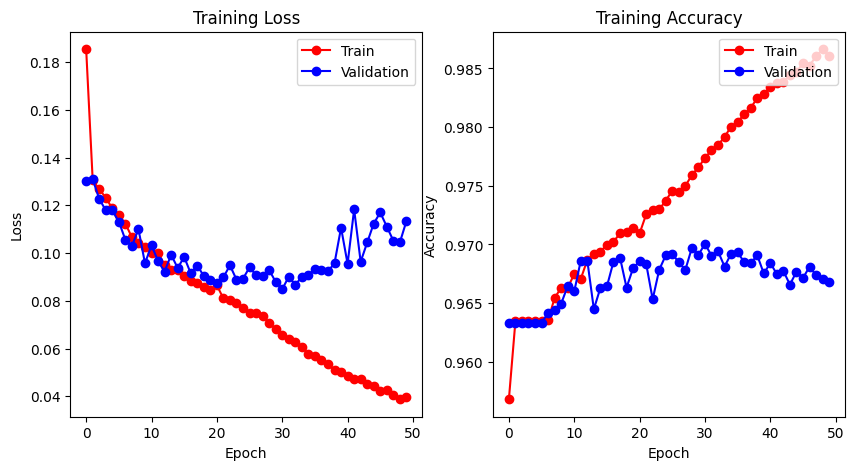

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'ro-')
plt.plot(history.history['val_loss'], 'bo-')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.subplot(1,2,2)
plt.plot(history.history['binary_accuracy'],'ro-')
plt.plot(history.history['val_binary_accuracy'], 'bo-')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

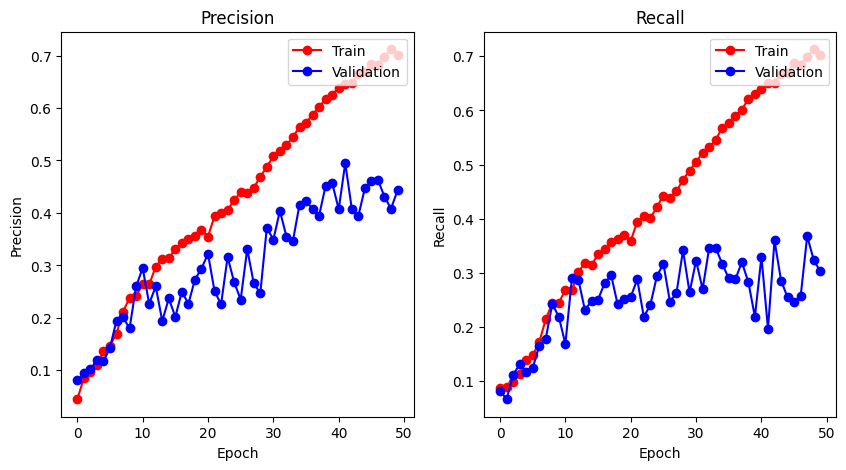

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(history.history['precision'], 'ro-')
plt.plot(history.history['val_precision'], 'bo-')
plt.title('Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.subplot(1,2,2)
plt.plot(history.history['recall'],'ro-')
plt.plot(history.history['val_recall'], 'bo-')
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
model.evaluate(test_dataset)

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 506ms/step - binary_accuracy: 0.9654 - iou: 0.2261 - loss: 0.1186 - precision: 0.4721 - recall: 0.3035


[0.10872665792703629,
 0.9677039384841919,
 0.45399999618530273,
 0.3109999895095825,
 0.22599999606609344]

In [ ]:
batch = next(iter(test_dataset))

In [ ]:
x, y = batch
y_pred = model.predict(x)
print(x.shape, y_pred.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
(16, 256, 256, 3) (16, 256, 256, 1)


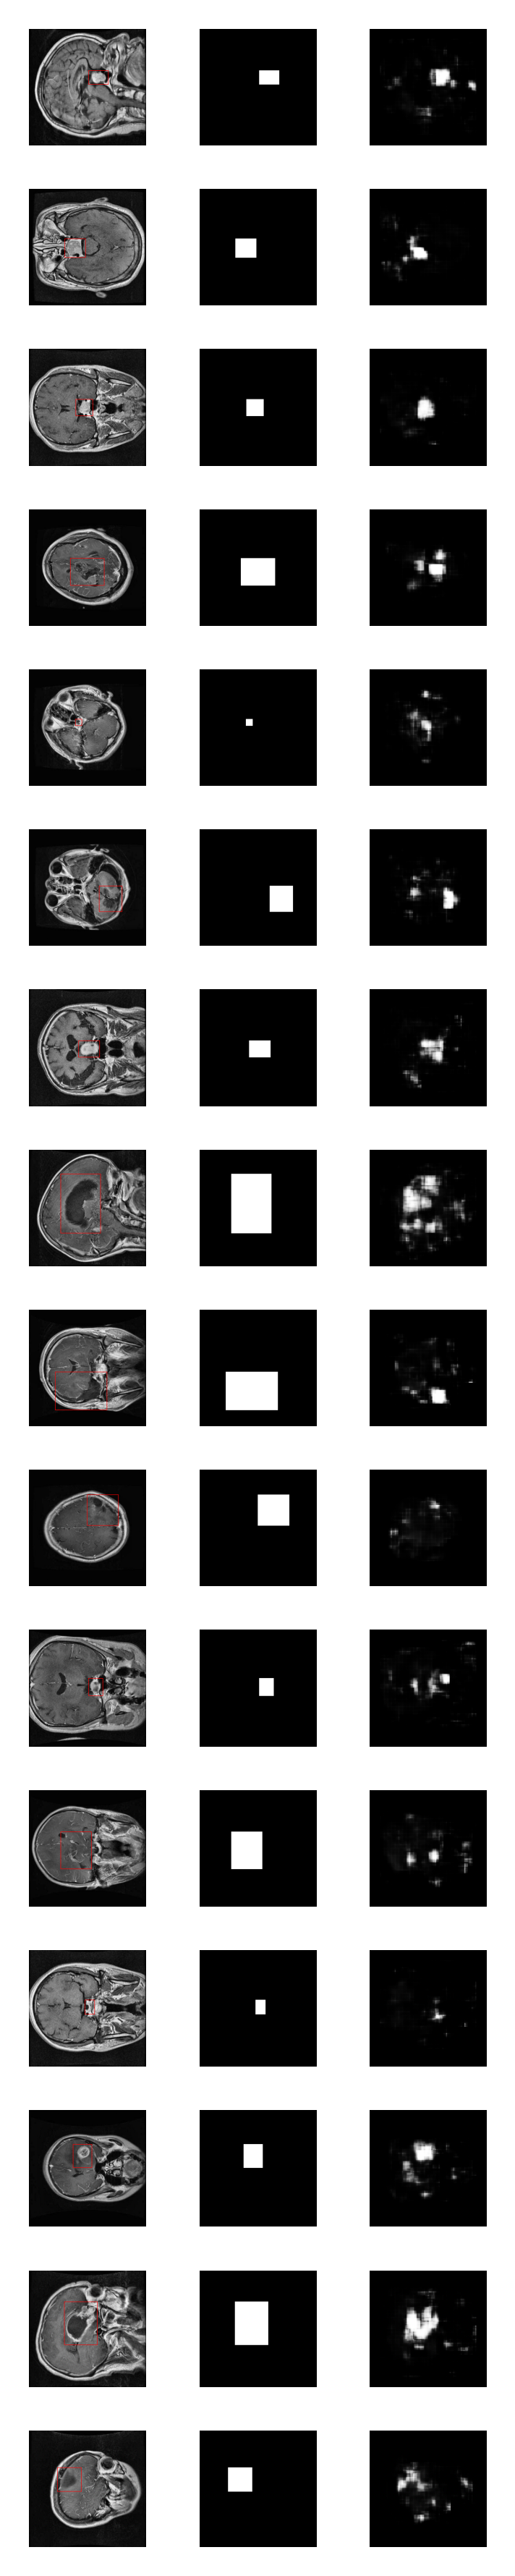

In [ ]:
plt.figure(figsize=(2,9), dpi=400)
j=0
i=0
while i < 16*3:
  plt.subplot(16,3,i+1)
  # plt.imshow(x[j], cmap='gray')
  plt.imshow(get_masked_image(x[j].numpy(), y[j].numpy().astype(np.uint8), (0,0,255)), cmap='gray')
  plt.axis('off')
  plt.subplot(16,3,i+2)
  plt.imshow(y[j], cmap='gray')
  plt.axis('off')
  plt.subplot(16,3,i+3)
  plt.imshow(y_pred[j], cmap='gray')
  plt.axis('off')
  i+=3
  j+=1
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

In [ ]:
model.save("unet_model.keras")